## Исследование надёжности заёмщиков

Заказчик — кредитный отдел банка. Нужно разобраться, влияет ли семейное положение и количество детей клиента на факт погашения кредита в срок. Входные данные от банка — статистика о платёжеспособности клиентов.

Результаты исследования будут учтены при построении модели **кредитного скоринга** — специальной системы, которая оценивает способность потенциального заёмщика вернуть кредит банку.

### Шаг 1. Откройте файл с данными и изучите общую информацию. 

#### Общая информация
Работу над проектом начнем с ознакомления с общей информацией файла.

In [2]:
import pandas as pd
credit_scoring = pd.read_csv('/datasets/data.csv')
credit_scoring.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
children            21525 non-null int64
days_employed       19351 non-null float64
dob_years           21525 non-null int64
education           21525 non-null object
education_id        21525 non-null int64
family_status       21525 non-null object
family_status_id    21525 non-null int64
gender              21525 non-null object
income_type         21525 non-null object
debt                21525 non-null int64
total_income        19351 non-null float64
purpose             21525 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


Итак, мы обнаружили отсутствующие значения в столбцах days_employed(трудовой стаж) и total_income(доход в месяц).<br/>
Кроме того, количество пропусков в этих колонках одинаковое.

#### Первый взгляд на таблицу
Посмотрим первые 10 строк таблицы.

In [5]:
credit_scoring.head(10)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу
5,0,-926.185831,27,высшее,0,гражданский брак,1,M,компаньон,0,255763.565419,покупка жилья
6,0,-2879.202052,43,высшее,0,женат / замужем,0,F,компаньон,0,240525.971920,операции с жильем
7,0,-152.779569,50,СРЕДНЕЕ,1,женат / замужем,0,M,сотрудник,0,135823.934197,образование
8,2,-6929.865299,35,ВЫСШЕЕ,0,гражданский брак,1,F,сотрудник,0,95856.832424,на проведение свадьбы
9,0,-2188.756445,41,среднее,1,женат / замужем,0,M,сотрудник,0,144425.938277,покупка жилья для семьи


Сразу обозначим проблемы, которые заметны невооруженным глазом(ну, или чуть-чуть вооруженным):
- Отрицательные значения в стаже;
- Разные регистры в образовании.

#### Отсутствующие значения

Посмотрим на строки с отсутствующими значениями.

In [6]:
credit_scoring[credit_scoring['total_income'].isnull()].head(10)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
12,0,NaN,65,среднее,1,гражданский брак,1,M,пенсионер,0,NaN,сыграть свадьбу
26,0,NaN,41,среднее,1,женат / замужем,0,M,госслужащий,0,NaN,образование
29,0,NaN,63,среднее,1,Не женат / не замужем,4,F,пенсионер,0,NaN,строительство жилой недвижимости
41,0,NaN,50,среднее,1,женат / замужем,0,F,госслужащий,0,NaN,сделка с подержанным автомобилем
55,0,NaN,54,среднее,1,гражданский брак,1,F,пенсионер,1,NaN,сыграть свадьбу
65,0,NaN,21,среднее,1,Не женат / не замужем,4,M,компаньон,0,NaN,операции с коммерческой недвижимостью
67,0,NaN,52,высшее,0,женат / замужем,0,F,пенсионер,0,NaN,покупка жилья для семьи
72,1,NaN,32,высшее,0,женат / замужем,0,M,госслужащий,0,NaN,операции с коммерческой недвижимостью
82,2,NaN,50,высшее,0,женат / замужем,0,F,сотрудник,0,NaN,жилье
83,0,NaN,52,среднее,1,женат / замужем,0,M,сотрудник,0,NaN,жилье


Отсутствующие значения по столбцам трудового стажа и дохода находятся в одних строках.<br/> Вероятно, заёмщик не смог предоставить документы с места работы, подтверждающие доход и стаж.

#### Уникальные значения в столбцах

Посмотрим на уникальные значения в столбцах, где это имеет смысл. Очевидно, что в стаже и доходах практически все значения будут уникальными.

##### Дети

In [7]:
credit_scoring['children'].value_counts()

 0     14149
 1      4818
 2      2055
 3       330
 20       76
-1        47
 4        41
 5         9
Name: children, dtype: int64

Отрицательные дети оказывают негативное влияние на нашу таблицу. Нужно им помочь с исправлением.

##### Возраст клиента

In [8]:
credit_scoring['dob_years'].value_counts()

35    617
40    609
41    607
34    603
38    598
42    597
33    581
39    573
31    560
36    555
44    547
29    545
30    540
48    538
37    537
50    514
43    513
32    510
49    508
28    503
45    497
27    493
56    487
52    484
47    480
54    479
46    475
58    461
57    460
53    459
51    448
59    444
55    443
26    408
60    377
25    357
61    355
62    352
63    269
64    265
24    264
23    254
65    194
66    183
22    183
67    167
21    111
0     101
68     99
69     85
70     65
71     58
20     51
72     33
19     14
73      8
74      6
75      1
Name: dob_years, dtype: int64

Слишком молодые заёмщики возврастом 0 лет. Нужно разобраться.

##### Образование

In [9]:
credit_scoring['education'].value_counts()

среднее                13750
высшее                  4718
СРЕДНЕЕ                  772
Среднее                  711
неоконченное высшее      668
ВЫСШЕЕ                   274
Высшее                   268
начальное                250
Неоконченное высшее       47
НЕОКОНЧЕННОЕ ВЫСШЕЕ       29
НАЧАЛЬНОЕ                 17
Начальное                 15
ученая степень             4
УЧЕНАЯ СТЕПЕНЬ             1
Ученая степень             1
Name: education, dtype: int64

Разными регистрами нас не испугать!

##### Семейное положение

In [10]:
credit_scoring['family_status'].value_counts()

женат / замужем          12380
гражданский брак          4177
Не женат / не замужем     2813
в разводе                 1195
вдовец / вдова             960
Name: family_status, dtype: int64

Кажется пристойным, но регистры лучше уравнять.

##### Пол клиента

In [11]:
credit_scoring['gender'].value_counts()

F      14236
M       7288
XNA        1
Name: gender, dtype: int64

Некто, с гендером XNA, проник в нашу таблицу, но это не осталось незамеченным.<br/> Похоже на имя ребенка Илона Маска. Но именам не место в столбце с гендерами. <br/> Удалим одну строку, не страшно.

##### Тип занятости

In [12]:
credit_scoring['income_type'].value_counts()

сотрудник          11119
компаньон           5085
пенсионер           3856
госслужащий         1459
предприниматель        2
безработный            2
студент                1
в декрете              1
Name: income_type, dtype: int64

Очень мало кредитуемых предпринимателей, безработных, студентов и людей в декрете. <br/>Кредит, выдаваемый человеку без подтвержденного стабильного дохода, является исключением из правил.

##### Просрочка

In [13]:
credit_scoring['debt'].value_counts()

0    19784
1     1741
Name: debt, dtype: int64

In [14]:
percent_of_debt = credit_scoring['debt'].sum() / credit_scoring['debt'].count()
print('Количество кредитов с просрочкой в выплате составляет {:.0%}'.format(percent_of_debt))

Количество кредитов с просрочкой в выплате составляет 8%


##### Общий доход

Посмотрим максимальный, минимальный, медианный и средний доходы клиентов банка.

In [15]:
max_total_income = credit_scoring['total_income'].max()
print('Максимальный доход среди клиентов составляет',max_total_income)

min_total_income = credit_scoring['total_income'].min()
print('Минимальный доход среди клиентов составляет',min_total_income)

median_total_income = credit_scoring['total_income'].median()
print('Медианный доход среди клиентов составляет', median_total_income)

mean_total_income = credit_scoring['total_income'].mean()
print('Средний доход среди клиентов составляет', mean_total_income)

Максимальный доход среди клиентов составляет 2265604.028722744
Минимальный доход среди клиентов составляет 20667.26379327158
Медианный доход среди клиентов составляет 145017.93753253992
Средний доход среди клиентов составляет 167422.30220817294


Разница между максимальным и минимальным доходами очень большая, более чем на два порядка.

##### Цель получения кредита

In [16]:
credit_scoring['purpose'].value_counts()

свадьба                                   797
на проведение свадьбы                     777
сыграть свадьбу                           774
операции с недвижимостью                  676
покупка коммерческой недвижимости         664
покупка жилья для сдачи                   653
операции с жильем                         653
операции с коммерческой недвижимостью     651
покупка жилья                             647
жилье                                     647
покупка жилья для семьи                   641
строительство собственной недвижимости    635
недвижимость                              634
операции со своей недвижимостью           630
строительство жилой недвижимости          626
покупка недвижимости                      624
строительство недвижимости                620
покупка своего жилья                      620
ремонт жилью                              612
покупка жилой недвижимости                607
на покупку своего автомобиля              505
заняться высшим образованием      

Как много целей кредита, что-то подсказывает, что тут много повторов.

### Вывод по предпросмотру

Выгрузка кажется очень неплохой.
План работ следующий:
1. Пропуски. Устранить пропуски в колонках дохода и стажа;
2. Трудовой стаж. Отрицательные значения в стаже нужно взять по модулю. Нужно исправить ОЧЕНЬ большие значения.
3. Образование. Свести с одному регистру.
4. Дети. Исправить отрицательные значения в колонке детей и 20 приравнять к 2. разрыв (5-20) в количестве детей говорит о не верных данных.
5. Возраст клиента. Чтото сделать с нулевыми значениями(101штука).
6. Семейное положение. Свести к одному регистру.
7. Пол клиента. Удалить строку со значением XNA.
8. Цель получения кредита. Лемматизировать.

### Шаг 2. Предобработка данных

#### Обработка пропусков

Заменим отсутствующие значения - нулевой строкой.<br/>
В отличие от медианных/средних значений, это не будет создавать ложных представлений. И в случае необходимости, они могут быть легко заменены потребными значениями.

In [14]:
credit_scoring['total_income'] = credit_scoring['total_income'].fillna(value = 0)
credit_scoring['days_employed'] = credit_scoring['days_employed'].fillna(value = 0)

#### Исправление ошибок в данных

Разберемся с отрицательными значениями в колонке трудового стажа и количества детей.

In [15]:
credit_scoring['days_employed'] = credit_scoring['days_employed'].abs()
credit_scoring['children'] = credit_scoring['children'].abs()

Трудовой стаж должен быть указан в днях. В таблице имеются значения, которые при переводе в года, превыщают тысячу лет.<br/> 
Ошибка могла возникнуть из-за внесения вместо 1 дня - 24 часов. 
Отсутствуют значения от 19000 до 328000. <br/>
Возьмем, с запапасом, 80 лет стажа - в рамках нормы.<br/> Превышающие значения переведем в дни.

In [16]:
credit_scoring.loc[credit_scoring['days_employed'] >= 29200, 'days_employed'] = credit_scoring['days_employed'] / 24

В таблице присутствуют значения от 0 до 5, а далее 20!<br/>
Признаем значение 20 - ошибкой.<br/>
Исправим количество детей c 20 на 2.

In [17]:
credit_scoring.loc[credit_scoring['children'] == 20, 'children'] = 2

Нулевые значения в колонке возраста решено оставить без изменений.<br/>Если в данный момент наши задачи не требуют возрастного параметра, лучше не замещать нулевые значения - очевидно подложными.

Приведем к нижнему регистру колонки образования и семейного положения

In [10]:
credit_scoring['education'] = credit_scoring['education'].str.lower()
credit_scoring['family_status'] = credit_scoring['family_status'].str.lower()

Удалим строку с непонятным значением в графе пола

In [11]:
credit_scoring = credit_scoring.loc[credit_scoring['gender'] != 'XNA']

Убедимся, что отсутствующих значений не осталось

In [12]:
credit_scoring.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21524 entries, 0 to 21524
Data columns (total 12 columns):
children            21524 non-null int64
days_employed       21524 non-null float64
dob_years           21524 non-null int64
education           21524 non-null object
education_id        21524 non-null int64
family_status       21524 non-null object
family_status_id    21524 non-null int64
gender              21524 non-null object
income_type         21524 non-null object
debt                21524 non-null int64
total_income        21524 non-null float64
purpose             21524 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 2.1+ MB


Посмотрим, как выглядит наша обновлённая таблица.

In [13]:
credit_scoring.head(10)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,5623.422610,33,среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,14177.753002,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу
5,0,926.185831,27,высшее,0,гражданский брак,1,M,компаньон,0,255763.565419,покупка жилья
6,0,2879.202052,43,высшее,0,женат / замужем,0,F,компаньон,0,240525.971920,операции с жильем
7,0,152.779569,50,среднее,1,женат / замужем,0,M,сотрудник,0,135823.934197,образование
8,2,6929.865299,35,высшее,0,гражданский брак,1,F,сотрудник,0,95856.832424,на проведение свадьбы
9,0,2188.756445,41,среднее,1,женат / замужем,0,M,сотрудник,0,144425.938277,покупка жилья для семьи


### Вывод

Мы успешно провели подготовку данных:
- заменили отсутствующие значения в колонках
- исправили очевидные ошибки в количестве детей и отработанных дней
- **намеренно**  не стали трогать нулевой возраст заёмщиков
- привели к нижнему регистру данных в колонках образования и семейного положения
- устранили строку с подозрительным гендером 'XNA'

Теперь мы сможем строить свои выводы, на основании более чем 21тысяч подготовленных наблюдений.

### Замена типа данных

Заменим типы данных трудового стажа и дохода.

In [26]:
credit_scoring['days_employed'] = credit_scoring['days_employed'].astype('int')
credit_scoring['total_income'] = credit_scoring['total_income'].astype('int')

credit_scoring.head(10)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,8437,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875,покупка жилья
1,1,4024,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080,приобретение автомобиля
2,0,5623,33,среднее,1,женат / замужем,0,M,сотрудник,0,145885,покупка жилья
3,3,4124,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628,дополнительное образование
4,0,14177,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616,сыграть свадьбу
5,0,926,27,высшее,0,гражданский брак,1,M,компаньон,0,255763,покупка жилья
6,0,2879,43,высшее,0,женат / замужем,0,F,компаньон,0,240525,операции с жильем
7,0,152,50,среднее,1,женат / замужем,0,M,сотрудник,0,135823,образование
8,2,6929,35,высшее,0,гражданский брак,1,F,сотрудник,0,95856,на проведение свадьбы
9,0,2188,41,среднее,1,женат / замужем,0,M,сотрудник,0,144425,покупка жилья для семьи


### Вывод

Ни в одном из двух столбцов(трудовой стаж и доход) значение после запятой не имело существенной ценности.<br/>
Заменили типы данных с float на int.

### Обработка дубликатов

Посмотрим насколько наше положение бедственно, выведем количество дубликатов в таблице.

In [18]:
credit_scoring.duplicated().sum()

71

Всего то 71 дубль.<br/> Может смиримся и оставим?<br/> Ну, конечно же - нет!

In [19]:
credit_scoring = credit_scoring.drop_duplicates().reset_index(drop=True)

In [20]:
print('Количество дубликатов в таблице - ', credit_scoring.duplicated().sum())

Количество дубликатов в таблице -  0


### Вывод

Без дубликатов таблица стала чуть меньше, но значительно более правдива.

### Лемматизация

Импортируем необходимые инструменты

In [21]:
from pymystem3 import Mystem
from collections import Counter
m = Mystem()

Напишем функцию для лемматизации

In [22]:
def to_lemmas(row):
    lemmas = m.lemmatize(row)
    lemmas_string = ''.join(lemmas)
    return lemmas_string

Проверим работу функции

In [23]:
to_lemmas('приветствуем миросотые кумяблики')

'приветствовать миросотый кумяблик\n'

Добавляем новый столбец cо строками из лемм и применяем функцию to_lemmas

In [24]:
credit_scoring['lemmas_string'] = credit_scoring['purpose'].apply(to_lemmas)

Посмотрим, на что же стала похожа наша многострадальная таблица.

In [25]:
credit_scoring.head(10)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,lemmas_string
0,1,8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья,покупка жилье\n
1,1,4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля,приобретение автомобиль\n
2,0,5623.422610,33,среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья,покупка жилье\n
3,3,4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование,дополнительный образование\n
4,0,14177.753002,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу,сыграть свадьба\n
5,0,926.185831,27,высшее,0,гражданский брак,1,M,компаньон,0,255763.565419,покупка жилья,покупка жилье\n
6,0,2879.202052,43,высшее,0,женат / замужем,0,F,компаньон,0,240525.971920,операции с жильем,операция с жилье\n
7,0,152.779569,50,среднее,1,женат / замужем,0,M,сотрудник,0,135823.934197,образование,образование\n
8,2,6929.865299,35,высшее,0,гражданский брак,1,F,сотрудник,0,95856.832424,на проведение свадьбы,на проведение свадьба\n
9,0,2188.756445,41,среднее,1,женат / замужем,0,M,сотрудник,0,144425.938277,покупка жилья для семьи,покупка жилье для семья\n


Так она же стала ещё лучше!

### Вывод

Лемматизация прошла успешно! 
Можно с чистым сердцем загрузить новый столбец lemmas_string в описание товаров на aliexpress.

### Категоризация данных

Посмотрим уникальные значения в новом столбце лемм, это поможет нам выделить категории 

In [26]:
credit_scoring['lemmas_string'].unique()

array(['покупка жилье\n', 'приобретение автомобиль\n',
       'дополнительный образование\n', 'сыграть свадьба\n',
       'операция с жилье\n', 'образование\n', 'на проведение свадьба\n',
       'покупка жилье для семья\n', 'покупка недвижимость\n',
       'покупка коммерческий недвижимость\n',
       'покупка жилой недвижимость\n',
       'строительство собственный недвижимость\n', 'недвижимость\n',
       'строительство недвижимость\n',
       'на покупка подержать автомобиль\n',
       'на покупка свой автомобиль\n',
       'операция с коммерческий недвижимость\n',
       'строительство жилой недвижимость\n', 'жилье\n',
       'операция со свой недвижимость\n', 'автомобиль\n',
       'заниматься образование\n', 'сделка с подержанный автомобиль\n',
       'получение образование\n', 'свадьба\n',
       'получение дополнительный образование\n', 'покупка свой жилье\n',
       'операция с недвижимость\n', 'получение высокий образование\n',
       'свой автомобиль\n', 'сделка с автомобиль

Столько всего интересного, глаза разбегаются, нужно категоризировать.<br/>
Напишем функцию для категоризации целей кредитов.

In [27]:
def categorization(row):
    if 'образование' in row:
        return 'образование'
    if 'автомобиль' in row:
        return 'автомобиль'
    if 'недвижимость' in row or 'жилье' in row:
        return 'недвижимость'
    if 'свадьба' in row:
        return 'свадьба'
    return 'другое'

Посмотрим на нашу новенькую функцию в деле.

In [28]:
credit_scoring['purpose_category'] = credit_scoring['lemmas_string'].apply(categorization)
credit_scoring['purpose_category'].value_counts()

недвижимость    10810
автомобиль       4306
образование      4013
свадьба          2324
Name: purpose_category, dtype: int64

Узнаем пять категорий доходов, равных по колличеству резидентов, по которым нам нужно рапределить заёмщиков.

In [29]:
pd.qcut(credit_scoring['total_income'],5).unique()

[(214607.418, 2265604.029], (79166.216, 116402.085], (116402.085, 156422.818], (156422.818, 214607.418], (-0.001, 79166.216]]
Categories (5, interval[float64]): [(-0.001, 79166.216] < (79166.216, 116402.085] < (116402.085, 156422.818] < (156422.818, 214607.418] < (214607.418, 2265604.029]]

Напишем фукцию, которая распределит клиентов банка по пяти группам, в зависимости от уровня доходов.

In [30]:
def categorization_for_income(total_income):
    if total_income < 79166:
        return 'очень низкий уровень доходов'
    if 79166 <= total_income < 116401:
        return 'низкий уровень доходов'
    if 116401 <= total_income < 156422:
        return 'средний уровень доходов'
    if 156422 <= total_income < 214607:
        return 'высокий уровень доходов'
    if total_income >= 214607:
        return 'очень высокий уровень доходов'
    return 'другое'


При помощи функции categorization_for_income, добавим новый столбец "категория доходов". Оценим распределение.

In [31]:
credit_scoring['income_category'] = credit_scoring['total_income'].apply(categorization_for_income)
print(credit_scoring['income_category'].value_counts())

низкий уровень доходов           4291
средний уровень доходов          4291
очень высокий уровень доходов    4291
высокий уровень доходов          4290
очень низкий уровень доходов     4290
Name: income_category, dtype: int64


In [32]:
credit_scoring.head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,lemmas_string,purpose_category,income_category
0,1,8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья,покупка жилье\n,недвижимость,очень высокий уровень доходов
1,1,4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля,приобретение автомобиль\n,автомобиль,низкий уровень доходов
2,0,5623.422610,33,среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья,покупка жилье\n,недвижимость,средний уровень доходов
3,3,4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование,дополнительный образование\n,образование,очень высокий уровень доходов
4,0,14177.753002,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу,сыграть свадьба\n,свадьба,высокий уровень доходов


### Вывод

Видим, что в категории "другое" никаких значений не появилось.<br/> Это значит выделенных категорий достаточно, как в распределении по целям кредита, так и по уровню доходов.<br/>
Самой часто встречающаяся цель кредита - недвижимость, что не удивительно. Больше чем суммарно во всех остальных категориях.

### Шаг 3. Ответьте на вопросы

- Есть ли зависимость между наличием детей и возвратом кредита в срок?

In [33]:
group_by_children = credit_scoring.groupby('children').agg({'debt':['count','sum']})
group_by_children['probability_to_debt'] = group_by_children['debt']['sum'] / group_by_children['debt']['count']
group_by_children

debt       probability_to_debt
          count   sum                    
children                                 
0         14090  1063            0.075444
1          4855   445            0.091658
2          2128   202            0.094925
3           330    27            0.081818
4            41     4            0.097561
5             9     0            0.000000

Давайте объединим всех кредиторов с детьми, вне зависимсоти от их количества, и определим общую вероятность просрочки в выплатах.

In [34]:
group_by_children['debt']['sum'][1:6].sum()/group_by_children['debt']['count'][1:6].sum()

0.09208203178052424

In [35]:
credit_scoring.debt.mean()

0.08115415093460122

### Вывод

Определенно, наличие детей существенно усложняет выплату кредита в срок.<br/> Не важно, сколько у вас детей, вернуть кредит в срок будет в любом случае сложнее.

- Есть ли зависимость между семейным положением и возвратом кредита в срок?

In [36]:
group_by_family_status = credit_scoring.groupby('family_status').agg({'debt':['count','sum']})
group_by_family_status['probability_to_debt'] = group_by_family_status['debt']['sum'] / group_by_family_status['debt']['count']
group_by_family_status

debt      probability_to_debt
                       count  sum                    
family_status                                        
в разводе               1195   85            0.071130
вдовец / вдова           959   63            0.065693
гражданский брак        4150  388            0.093494
женат / замужем        12339  931            0.075452
не женат / не замужем   2810  274            0.097509

### Вывод

Для банка, самые интересные заёмщики - вдовы,вдовцы и разведёнки, они возвращают долги вовремя чаще всех.<br/>
Средняя ситуация по возврату в срок для замужних и женатых клиентов.<br/>
Ухудшается ситуация у клиентов в гражданском браке.<br/>
Худшими заёмщиками можно признать не женатых/не замужних.

- Есть ли зависимость между уровнем дохода и возвратом кредита в срок?

Выведем сводную таблицу, сгруппировав клиентов по категории дохода, оценим вероятность просрочки в выплате кредита.

In [37]:
group_by_income_category = credit_scoring.groupby('income_category').agg({'debt':['count','sum']})
group_by_income_category['probability_to_debt'] = group_by_income_category['debt']['sum'] / group_by_income_category['debt']['count']
group_by_income_category.sort_values('probability_to_debt')

debt      probability_to_debt
                              count  sum                    
income_category                                             
очень высокий уровень доходов  4291  300            0.069914
очень низкий уровень доходов   4290  333            0.077622
низкий уровень доходов         4291  363            0.084596
высокий уровень доходов        4290  370            0.086247
средний уровень доходов        4291  375            0.087392

### Вывод

Лучше всего ситуация в своевременных выплатах у людей получающих очень большие деньги, и как ни странно, у людей которых мы отнесли к людям с очень низким уровнем заработка.<br/> Самая плохая выплачиваемость у людей со средним заработком. Середина не всегда бывает "золотой".

- Как разные цели кредита влияют на его возврат в срок?

In [38]:
group_by_purpose_category = credit_scoring.groupby('purpose_category').agg({'debt':['count','sum']})
group_by_purpose_category['probability_to_debt'] = group_by_purpose_category['debt']['sum'] / group_by_purpose_category['debt']['count']
print(group_by_purpose_category)

                   debt      probability_to_debt
                  count  sum                    
purpose_category                                
автомобиль         4306  403            0.093590
недвижимость      10810  782            0.072340
образование        4013  370            0.092200
свадьба            2324  186            0.080034


### Вывод

За недвижимость люди платят своевременно значительно чаще.<br/>
Чуть хуже показатель у людей, которые женятся в кредит.<br/>
Самые плохие показатели у автолюбителей.

- Как пол заёмщика влияет на возврат кредита в срок?

In [39]:
group_by_gender = credit_scoring.groupby('gender').agg({'debt':['count','sum']})
group_by_gender['gender_to_debt'] = group_by_gender['debt']['sum'] / group_by_gender['debt']['count']
print(group_by_gender)

         debt      gender_to_debt
        count  sum               
gender                           
F       14174  994       0.070128
M        7279  747       0.102624


### Вывод

Женщины являются более ответственными плательщиками по кредитам.

### Шаг 4. Общий вывод

1.*Есть ли зависимость между наличием детей и возвратом кредита в срок?*

Зависимость на лицо.<br/>
Вероятность прочки для клиента без детей - 7,5%.<br/>
Вероятность прочки для клиентов с детьми - 9,2%.<br/>
Клиенты с детьми возвращают долги своевременно в 90.8% случаев, тогда как заёмщики без детей в 92,5%.<br/>

In [40]:
group_by_children.sort_values('probability_to_debt')

debt       probability_to_debt
          count   sum                    
children                                 
5             9     0            0.000000
0         14090  1063            0.075444
3           330    27            0.081818
1          4855   445            0.091658
2          2128   202            0.094925
4            41     4            0.097561

2.*Есть ли зависимость между семейным положением и возвратом кредита в срок?*

Да.<br/>
Для банка, самые интересные заёмщики - вдовы,вдовцы и разведенные, они возвращают долги вовремя чаще всех.<br/>
Средняя ситуация по возврату в срок для замужних и женатых клиентов.<br/>
Ухудшается ситуация у клиентов в гражданском браке.<br/>
Худшими заёмщиками можно признать не женатых/не замужних.

In [41]:
group_by_family_status.sort_values('probability_to_debt')

debt      probability_to_debt
                       count  sum                    
family_status                                        
вдовец / вдова           959   63            0.065693
в разводе               1195   85            0.071130
женат / замужем        12339  931            0.075452
гражданский брак        4150  388            0.093494
не женат / не замужем   2810  274            0.097509

3.*Есть ли зависимость между уровнем дохода и возвратом кредита в срок?*

Да, определенно. Средний класс платит значительно хуже остальных.<br/> 
Убедиться в этом можно, взглянув на цифры в таблице и на графике ниже.

In [42]:
group_by_income_category.sort_values('probability_to_debt')

debt      probability_to_debt
                              count  sum                    
income_category                                             
очень высокий уровень доходов  4291  300            0.069914
очень низкий уровень доходов   4290  333            0.077622
низкий уровень доходов         4291  363            0.084596
высокий уровень доходов        4290  370            0.086247
средний уровень доходов        4291  375            0.087392

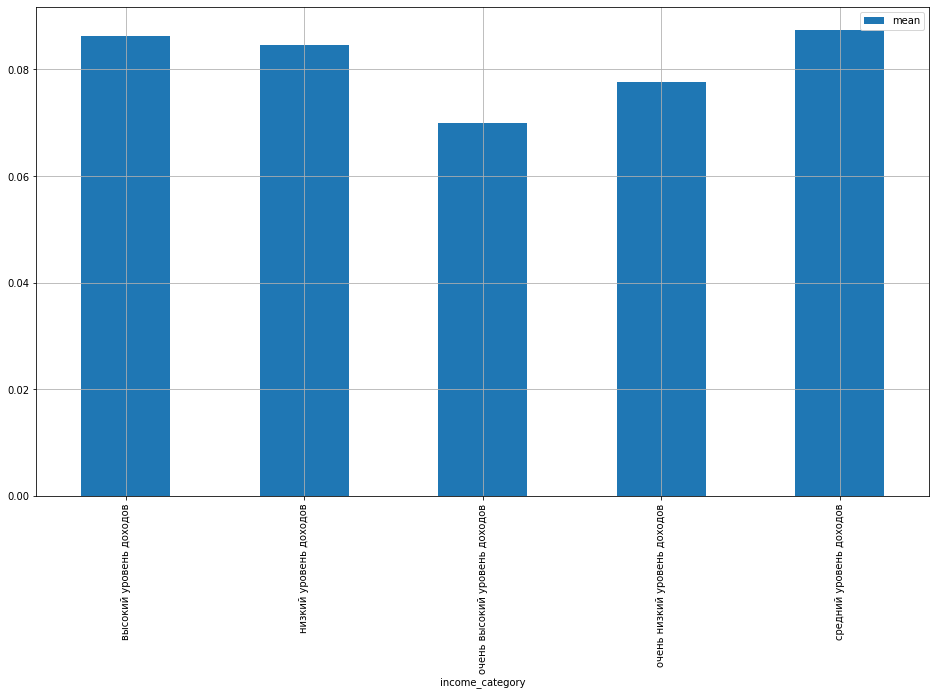

In [44]:
credit_scoring.groupby('income_category')['debt'].agg(['mean']).plot(kind='bar', grid=True,figsize=(16,9))

4.*Как разные цели кредита влияют на его возврат в срок?*

За недвижимость люди платят своевременно в 92.8% случаев.<br/>
Кредит на свадьбу возвращается без просрочки в 92% случаев.<br/>
Существенно ниже показатели у двух категорий целей кредитов:<br/>
Своевременная выплата кредита на образование составила 90,8%.<br/>
Хуже других возвращают долг клиенты, взявшие кредит на автомобиль, своевременные выплаты зафиксированы в 90,7% случаев.

In [55]:
group_by_purpose_category.sort_values('probability_to_debt')

debt      probability_to_debt
                  count  sum                    
purpose_category                                
недвижимость      10810  782            0.072340
свадьба            2324  186            0.080034
образование        4013  370            0.092200
автомобиль         4306  403            0.093590

# Итоги

Хорошие данные в выгрузке позволили нам провести оценку клиентов банка по широкому спектру показателей.<br/>
Больше всего кредитов люди берут на недвижимость, но и выплачивают кредиты за недвижимость стабильнее всего.<br/>
Клиенты с детьми выплачивают кредиты хуже.<br/>
Худшим клиентом для банка можно уверенно признать холостяка с четырьми детьми, со средней зарплатой, который покупает автомобиль в кредит.<br/>